STEP 1: Setup and data loading

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load Dataset
data = pd.read_csv("dataset2.csv") 

# Display the first and last few rows of the dataset to confirm structure
print(data.head())
print(data.tail())

   P_wt_percent  BPEI_Mn  AN_percent  EHA_percent  BA_percent  AC_mg-g  DT_C
0            30      600         9.1          0.0         0.0     69.8  71.0
1            30      600        18.2          0.0         0.0     57.1  57.0
2            30      600        24.5          0.0         0.0     51.9  57.0
3            30      600        36.4          0.0         0.0     48.4  43.0
4            30     1800         0.0          0.0         0.0     91.1  80.0
    P_wt_percent  BPEI_Mn  AN_percent  EHA_percent  BA_percent  AC_mg-g  DT_C
36            65      600        70.0          0.0        23.0    25.73  45.0
37            59    10000         3.0          4.0         1.0    52.53  96.7
38            49    10000         0.0          7.0         0.0    67.86  98.0
39            48    10000         0.0         13.0         0.0    52.13  76.3
40            30     1800         1.0          1.0         0.0    50.29  98.0


STEP 1.5: Understanding the new data

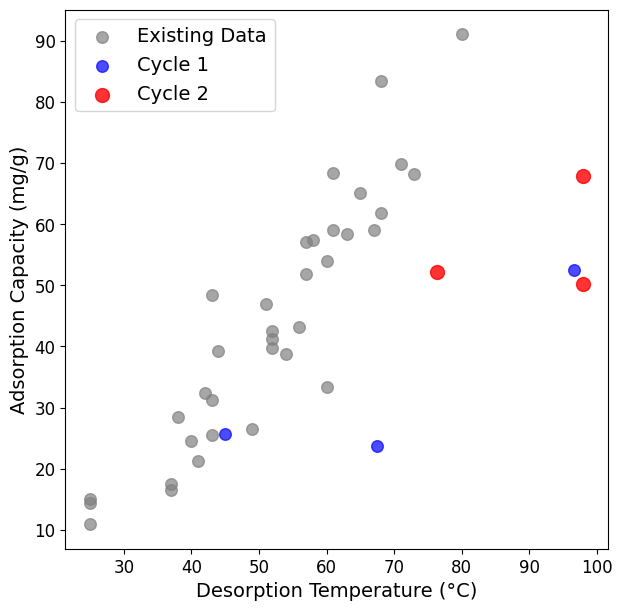

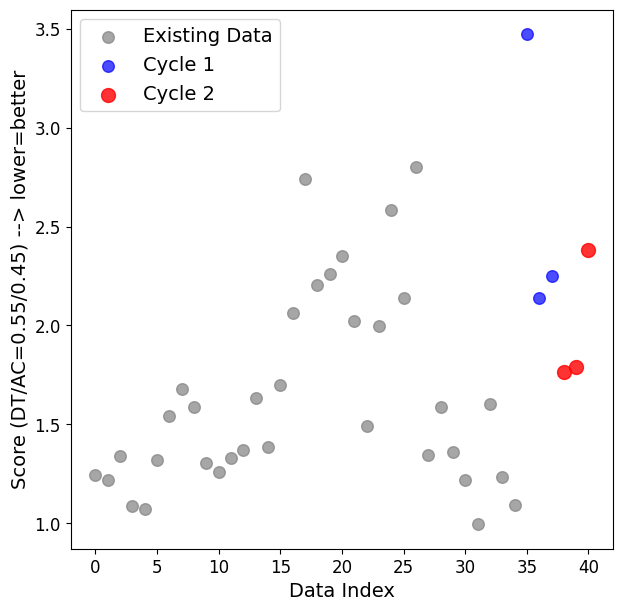

Summary of New Experimental Data:
    P_wt_percent  BPEI_Mn  AN_percent  EHA_percent  BA_percent  AC_mg-g  DT_C
38            49    10000         0.0          7.0         0.0    67.86  98.0
39            48    10000         0.0         13.0         0.0    52.13  76.3
40            30     1800         1.0          1.0         0.0    50.29  98.0

Best existing weighted score: 0.995
Best new weighted score: 1.765


In [2]:
# 1. Extract Data
c2_data = data.tail(3)  # Last 3 rows as new experimental data (Cycle 2)
c1_data = data.iloc[-6:-3]  # Rows -6 to -3 (Cycle 1)
existing_data = data.iloc[:-6]  # All data except the last 6 rows

# 2. Scatter Plot: Compare AC_mg-g and DT_C between new and existing data
plt.figure(figsize=(7, 7))
plt.scatter(existing_data['DT_C'], existing_data['AC_mg-g'], color='grey', s=70, alpha=0.7, label='Existing Data')
plt.scatter(c1_data['DT_C'], c1_data['AC_mg-g'], color='blue', s=70, alpha=0.7, label='Cycle 1')
plt.scatter(c2_data['DT_C'], c2_data['AC_mg-g'], color='red', s=100, alpha=0.8, label='Cycle 2')
plt.xlabel("Desorption Temperature (°C)", fontsize=14)
plt.ylabel("Adsorption Capacity (mg/g)", fontsize=14)
plt.legend(fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.show()

# 3. Scatter Plot: Weighted Score (DT/AC) for new and existing data
# Calculate weighted scores
weight_dt = 0.55  # Weight for DT_C
weight_ac = 0.45  # Weight for AC_mg-g

# Calculate scores with safeguards against division by zero
existing_scores = (weight_dt * existing_data['DT_C']) / (weight_ac * existing_data['AC_mg-g']).replace(0, float('inf'))
c1_scores = (weight_dt * c1_data['DT_C']) / (weight_ac * c1_data['AC_mg-g']).replace(0, float('inf'))
c2_scores = (weight_dt * c2_data['DT_C']) / (weight_ac * c2_data['AC_mg-g']).replace(0, float('inf'))

# Create scatter plot for weighted scores
plt.figure(figsize=(7, 7))
plt.scatter(range(len(existing_scores)), existing_scores, color='grey', s=70, alpha=0.7, label='Existing Data')
plt.scatter([len(existing_scores) + i for i in range(len(c1_scores))], c1_scores, color='blue', s=70, alpha=0.7, label='Cycle 1')
plt.scatter([len(existing_scores) + len(c1_scores) + i for i in range(len(c2_scores))], c2_scores, color='red', s=100, alpha=0.8, label='Cycle 2')
plt.xlabel("Data Index", fontsize=14)
plt.ylabel("Score (DT/AC=0.55/0.45) --> lower=better", fontsize=14)
plt.legend(fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.show()

# 4. Print Summary of New Data
print("Summary of New Experimental Data:")
print(c2_data[['P_wt_percent', 'BPEI_Mn', 'AN_percent', 'EHA_percent', 'BA_percent', 'AC_mg-g', 'DT_C']])

# 5. Compare the Best Weighted Scores
best_existing_score = existing_scores.min()
best_new_score = c2_scores.min()

print(f"\nBest existing weighted score: {best_existing_score:.3f}")
print(f"Best new weighted score: {best_new_score:.3f}")


STEP 2: Define features and labels

In [3]:
# Define features (synthesis parameters) and labels (target properties)
features = data[['P_wt_percent', 'BPEI_Mn', 'AN_percent', 'EHA_percent', 'BA_percent']]
labels = data[['AC_mg-g', 'DT_C']]

# Display shapes to confirm
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (41, 5)
Labels shape: (41, 2)


STEP 3: Train initial random forest models

In [4]:

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for AC_mg-g: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
AC_mg-g Model Evaluation:
MAE: 11.296
RMSE: 13.719
R²: -0.065
R² on full dataset: 0.8614618532300469


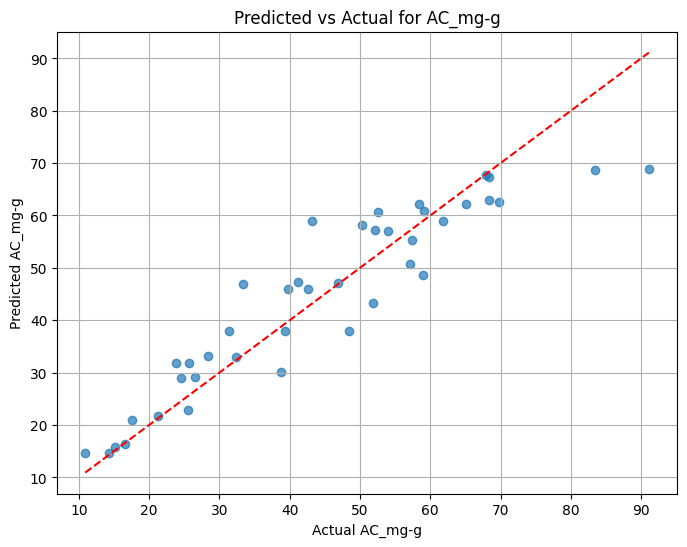

In [5]:
# Train Random Forest for AC_mg-g
ac_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                              param_grid=param_grid, cv=5, 
                              scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
ac_grid_search.fit(features, labels['AC_mg-g'])
ac_model = ac_grid_search.best_estimator_
print("Best parameters for AC_mg-g:", ac_grid_search.best_params_)

# Evaluate AC_mg-g model
ac_mae_scores = cross_val_score(ac_model, features, labels['AC_mg-g'], cv=5, scoring='neg_mean_absolute_error')
ac_rmse_scores = cross_val_score(ac_model, features, labels['AC_mg-g'], cv=5, scoring='neg_root_mean_squared_error')
ac_r2_scores = cross_val_score(ac_model, features, labels['AC_mg-g'], cv=5, scoring='r2')
# R² on the entire dataset
y_pred_ac = ac_model.predict(features)
r2_full_data_ac = r2_score(labels['AC_mg-g'], y_pred_ac)

# Display evaluation metrics
print("AC_mg-g Model Evaluation:")
print(f"MAE: {-np.mean(ac_mae_scores):.3f}")
print(f"RMSE: {-np.mean(ac_rmse_scores):.3f}")
print(f"R²: {np.mean(ac_r2_scores):.3f}")
print("R² on full dataset:", r2_full_data_ac)

# Visualization: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(labels['AC_mg-g'], y_pred_ac, alpha=0.7)
plt.plot([labels['AC_mg-g'].min(), labels['AC_mg-g'].max()], 
         [labels['AC_mg-g'].min(), labels['AC_mg-g'].max()], 'r--')
plt.title('Predicted vs Actual for AC_mg-g')
plt.xlabel('Actual AC_mg-g')
plt.ylabel('Predicted AC_mg-g')
plt.grid()
plt.show()

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for DT_C: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
DT_C Model Evaluation:
MAE: 9.773
RMSE: 11.161
R²: 0.327
R² on full dataset: 0.9532800475021959


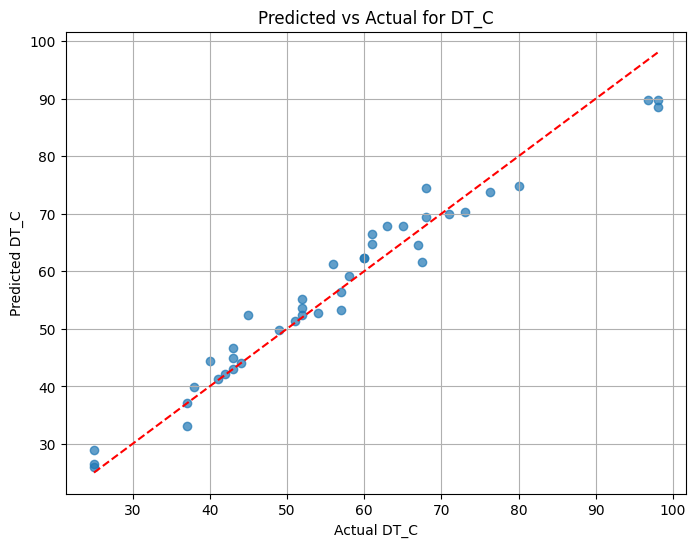

In [6]:
# Train Random Forest for DT_C
dt_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                              param_grid=param_grid, cv=5, 
                              scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
dt_grid_search.fit(features, labels['DT_C'])
dt_model = dt_grid_search.best_estimator_
print("Best parameters for DT_C:", dt_grid_search.best_params_)

# Evaluate DT_C model
dt_mae_scores = cross_val_score(dt_model, features, labels['DT_C'], cv=5, scoring='neg_mean_absolute_error')
dt_rmse_scores = cross_val_score(dt_model, features, labels['DT_C'], cv=5, scoring='neg_root_mean_squared_error')
dt_r2_scores = cross_val_score(dt_model, features, labels['DT_C'], cv=5, scoring='r2')
# R² on the entire dataset
y_pred_dt = dt_model.predict(features)
r2_full_data_dt = r2_score(labels['DT_C'], y_pred_dt)

# Display evaluation metrics
print("DT_C Model Evaluation:")
print(f"MAE: {-np.mean(dt_mae_scores):.3f}")
print(f"RMSE: {-np.mean(dt_rmse_scores):.3f}")
print(f"R²: {np.mean(dt_r2_scores):.3f}")
print("R² on full dataset:", r2_full_data_dt)

# Visualization: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(labels['DT_C'], y_pred_dt, alpha=0.7)
plt.plot([labels['DT_C'].min(), labels['DT_C'].max()], 
         [labels['DT_C'].min(), labels['DT_C'].max()], 'r--')
plt.title('Predicted vs Actual for DT_C')
plt.xlabel('Actual DT_C')
plt.ylabel('Predicted DT_C')
plt.grid()
plt.show()

STEP 4: Define the optimized objective function

In [7]:
def objective_function(x):
    """
    Predicts adsorption capacity and desorption temperature for given synthesis parameters 
    using the two trained Random Forest models and combines them into a single weighted objective score.
    """
    # Convert parameters to DataFrame format for prediction
    params = pd.DataFrame(x, columns=['P_wt_percent', 'BPEI_Mn', 'AN_percent', 'EHA_percent', 'BA_percent'])
    
    # Predict using the separate models
    predicted_ac = ac_model.predict(params)  # Predictions from AC model
    predicted_dt = dt_model.predict(params)  # Predictions from DT model
    
    # Apply weights to DT and AC
    weight_dt = 0.55  # Weight for desorption temperature
    weight_ac = 0.45  # Weight for adsorption capacity
    
    # Combine into a single score (minimize weighted DT/AC)
    weighted_objective_score = ((weight_dt * predicted_dt) / (weight_ac * predicted_ac)).reshape(-1, 1)
    
    # Return the score for minimization in GPyOpt
    return weighted_objective_score

STEP 5: Set bounds for optimization

In [8]:
# Define Bounds for Synthesis Parameters with Discrete Values
bounds = [
    {'name': 'P_wt_percent', 'type': 'discrete', 'domain': np.arange(10, 66, 1)},
    {'name': 'BPEI_Mn', 'type': 'discrete', 'domain': [600, 1800, 10000]},
    {'name': 'AN_percent', 'type': 'discrete', 'domain': np.arange(0, 101, 1)},
    {'name': 'EHA_percent', 'type': 'discrete', 'domain': np.arange(1, 101, 1)},
    {'name': 'BA_percent', 'type': 'discrete', 'domain': np.arange(0, 101, 1)}
]

# Define the constraint that the sum of AN_percent, EHA_percent, and BA_percent should be <= 100
constraints = [{'name': 'sum_constraint', 'constraint': 'x[:,2] + x[:,3] + x[:,4] - 100'}]

STEP 6: Active learning loop with Bayesian optimization

# Cycle 3

In [9]:
from GPyOpt.methods import BayesianOptimization
from operator import itemgetter
from scipy.spatial.distance import euclidean

print("Cycle 2: Parameter Suggestion Phase")

# Step 1: Prepare Initial Conditions
initial_X = features.values  # Convert DataFrame to numpy array for GPyOpt
initial_Y = ((0.55 * labels['DT_C']) / (0.45 * labels['AC_mg-g'])).values.reshape(-1, 1)

# Step 2: Determine the Best (Lowest) Weighted Score
best_existing_score = initial_Y.min()
print(f"Best existing weighted score (minimized): {best_existing_score:.3f}")

# Step 3: Initialize Bayesian Optimization
np.random.seed(42)  # Set random seed for reproducibility
optimizer = BayesianOptimization(
    f=objective_function,
    domain=bounds,
    constraints=constraints,
    acquisition_type='MPI',  # Maximize Probability of Improvement
    acquisition_jitter=0.01,  # Focus on exploitation
    X=initial_X,
    Y=initial_Y
)

# Step 4: Run optimization for 100 iterations
optimizer.run_optimization(max_iter=100)

# Step 5: Enforce Diversity in Suggested Parameters
tested_params = optimizer.X
tested_scores = optimizer.Y

# Combine and sort parameters and scores by scores in ascending order (lower is better)
params_and_scores = sorted(zip(tested_params, tested_scores), key=itemgetter(1))

# Check for duplicates and enforce minimum distance
existing_params = features.values
filtered_params_and_scores = []

def is_far_enough(new_param_set, existing_sets, min_distance=5):
    """
    Ensure the new parameter set is sufficiently far from existing sets.
    """
    return all(euclidean(new_param_set, existing) >= min_distance for existing in existing_sets)

# Filter duplicates and near-duplicates with distance enforcement
for params, score in params_and_scores:
    if not any(np.allclose(params, row, atol=1e-3) for row in existing_params):  # Check duplicates
        if is_far_enough(params, [p for p, _ in filtered_params_and_scores], min_distance=5):
            filtered_params_and_scores.append((params, score))

# Step 6: Select Top 3 Parameter Sets
top_3_params_and_scores = filtered_params_and_scores[:3]

# Step 7: Display Results
print("\nTop suggested parameter sets for new experiments:")
for i, (params, score) in enumerate(top_3_params_and_scores):
    formatted_params = [int(param) for param in params]  # Convert to integers
    print(f"Set {i + 1}: Parameters = {formatted_params}, Weighted Score = {score[0]:.3f}")


Cycle 2: Parameter Suggestion Phase
Best existing weighted score (minimized): 0.995

Top suggested parameter sets for new experiments:
Set 1: Parameters = [50, 10000, 0, 6, 0], Weighted Score = 1.325
Set 2: Parameters = [41, 600, 18, 6, 14], Weighted Score = 1.361
Set 3: Parameters = [26, 10000, 19, 1, 0], Weighted Score = 1.395


Visualizing the suggested parameter sets

Ranks of suggested parameter scores among all scores:
       Score  Rank
41  1.324598    12
42  1.361066    17
43  1.395239    20


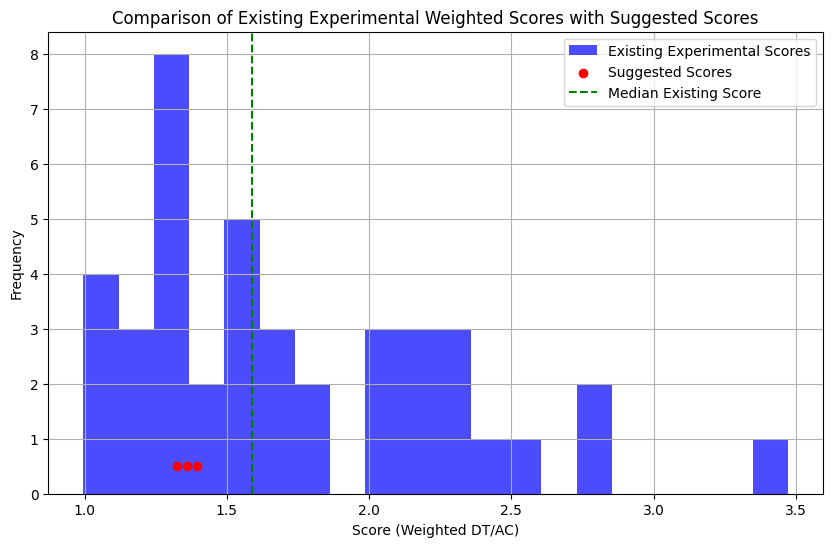

In [10]:
# Combine the suggested parameter scores with the existing scores (using Weighted DT/AC scores)
existing_scores = ((0.55 * labels['DT_C']) / (0.45 * labels['AC_mg-g'])).values  # Weighted DT/AC from experimental data
suggested_scores = [score[0] for _, score in top_3_params_and_scores]  # Suggested scores from optimization

# Create a DataFrame for visualization
score_data = pd.DataFrame({
    'Type': ['Existing'] * len(existing_scores) + ['Suggested'] * len(suggested_scores),
    'Score': np.concatenate([existing_scores, suggested_scores])
})

# Rank the suggested scores among all scores
ranked_scores = pd.DataFrame({
    'Score': np.concatenate([existing_scores, suggested_scores]),
    'Type': ['Existing'] * len(existing_scores) + ['Suggested'] * len(suggested_scores)
}).sort_values('Score')

# Assign ranks (lower is better)
ranked_scores['Rank'] = range(1, len(ranked_scores) + 1)

# Extract ranks of suggested scores
suggested_ranks = ranked_scores[ranked_scores['Type'] == 'Suggested'][['Score', 'Rank']]
print("Ranks of suggested parameter scores among all scores:")
print(suggested_ranks)

# Visualization: Score distribution with suggested scores highlighted
plt.figure(figsize=(10, 6))
plt.hist(existing_scores, bins=20, alpha=0.7, label='Existing Experimental Scores', color='blue')
plt.scatter(suggested_scores, [0.5] * len(suggested_scores), color='red', label='Suggested Scores', zorder=5)
plt.axvline(np.median(existing_scores), color='green', linestyle='--', label='Median Existing Score')
plt.title('Comparison of Existing Experimental Weighted Scores with Suggested Scores')
plt.xlabel('Score (Weighted DT/AC)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()